<a href="https://colab.research.google.com/github/jhejna/rlworkshop/blob/main/MF_RL_Workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Setup
Run the following cells to test the installation and make sure everything is working.

In [ ]:
# Check if we have GPU
import torch
if torch.cuda.is_available():
    print("GPU working!")
else:
    print("WARNING: The Colab runtime does not have GPU enabled.")
    print("         You should be able to train the models on CPU, but if you")
    print("         want GPU, enable it in Runtime > Change Runtime Type")

         You should be able to train the models on CPU, but if you
         want GPU, enable it in Runtime > Change Runtime Type


In [ ]:
%%bash
# install required system dependencies
apt-get install -y xvfb x11-utils
# install required python dependencies (might need to install additional gym extras depending)
pip install gym pyvirtualdisplay

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  libxxf86dga1
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libxxf86dga1 x11-utils xvfb
0 upgraded, 3 newly installed, 0 to remove and 14 not upgraded.
Need to get 993 kB of archives.
After this operation, 2,977 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxxf86dga1 amd64 2:1.1.4-1 [13.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 x11-utils amd64 7.7+3build1 [196 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.7 [783 kB]
Fetched 993 kB in 2s (506 kB/s)
Selecting previously unselected package libxxf86dga1:amd64.
(Reading database ... 144793 files and directories currently installed.)
Preparing to unpack .../libxxf86dga1_2%3a1.1.4-1_amd64.deb ...
Unpacking libxxf86dga1:amd64 (2:1.1.4-1) ...
Sel

In [ ]:
import pyvirtualdisplay
_display = pyvirtualdisplay.Display(visible=False, size=(640, 480))
_ = _display.start()

In [ ]:
# This should produce a non-blank output.
!echo $DISPLAY

:0


Episodes: 4


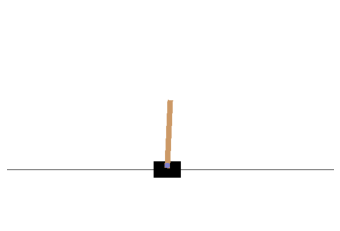

In [ ]:
# Test rendering a gym environment
import gym
import matplotlib.pyplot as plt
from IPython import display

env = gym.make('CartPole-v1')
num_ep = 0
obs = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
for _ in range(100):
    ac = env.action_space.sample()
    obs, reward, done, info = env.step(ac)
    img.set_data(env.render(mode='rgb_array')) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    if done:
        obs = env.reset()
        num_ep += 1
env.close()
del env
del img
print("Episodes:", num_ep)

# 1. REINFORCE
Here we'll implement the basic policy gradient algorithm REINFORCE in pytorch for the above cart-pole environment.

In [ ]:
# Import the required modules
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import gym

## a) Policy Network
First we need to implement the policy network. The policy network takes in observations and outputs actions that should be taken. Our policy will be implemented in the form of an MLP.

We're deliberately providing less skeleton code here, since this is one of the later workshops. It's a great opportunity to practice designing parts of your network and Googling the appropriate Pytorch (or Numpy, if needed) methods/classes that you'll need to implement it. That said, if you get stuck, definitely ask other workshop attendees or presenters for help!

Feel free to structure your network however you want, but a simple network (the solution just uses linear layers with ReLU activations) will do fine as CartPole is not too difficult an environment for a network to learn.

Our policy class must do the following:
1. Take in an observation from the environment, and return the action to take.
2. Given an observation and action, compute the log probability of taking that action under the current policy. This is used for computing the REINFORCE loss.

There are a few considerations to keep in mind:

**Discrete Actions**: The cartpole environment has a discrete action space: the cart can decide to move left or right, but can't choose how fast to move. This means we will need to output a categorical distribution. Think about the best way to implement this. (Hint: treat it like a classification problem). Your solution should ideally work for a discrete action space of any size, even though CartPole has only two actions.

**Exploration**: Remember that for RL to work, we need to explore. Make sure you have some randomness in your action selection, though it might be worth having a deterministic option that chooses the best known policy that the model can use at test time.

Define your class below.

Hints:
- Pytorch `Sequential` can be used to create networks where the output of each layer is fed into the next layer
- Remember, networks should inherit from `nn.Module` and implement crucial functions such as `__init__` and `forward`. Any such network can be used as the building block of another network -- feel free to create "helper" networks if you think they would be useful!

In [ ]:
# Define your network here!
# Feel free to do whatever you want, but we have provided a suggested interface

class MLP(nn.Module):

    pass

class Policy(nn.Module):

    # TODO: Fill in __init__

    # TODO: perhaps fill in forward

    def get_action(self, obs, deterministic=False):
        # Remember, we need to be able to explore!
        raise NotImplementedError

    def log_prob(self, action, obs):
        raise NotImplementedError

# NOTE: Remember that one thing you will need to compute when coding policy gradients is the
#       log probability of taking a given action from a state. Make sure your code can compute
#       compute this!

## b) Training Loop
Next, we need to actually train the policy network. This is done in two phases:
1. Data Collection: execute the policy in the enviornment and explore, collecting experience. For this you may need to refer to the gym environment interface. See how we did it in the setup or check out the documentation here: https://gym.openai.com/docs/
2. Update the policy: use the collected experience to update the policy using the computed policy gradient.

We have provided some skeleton code for the training loop. 

In [ ]:
# Hyper-parameters
iterations = 64
epochs_per_iter = 4
timesteps_per_iter = 2048
batch_size = 512
learning_rate = 1e-4
gamma = 0.99 # This is the discount factor
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

env = gym.make('CartPole-v1')
obs = env.reset()

# Initialize the policy network
policy = ... # YOUR CODE HERE

# Initialize the optimizer
optim = ... # YOUR CODE HERE

for iter in range(iterations):
    # First, collect data
    # Setup the data collection buffers
    observations = np.zeros((timesteps_per_iter, *env.observation_space.shape), dtype=np.float)
    actions = np.zeros((timesteps_per_iter, 1), np.float)
    rewards = np.zeros(timesteps_per_iter, np.float)
    dones = np.zeros(timesteps_per_iter, dtype=np.bool)
    
    # Collect the data
    for i in range(timesteps_per_iter):
        action = ... # YOUR CODE HERE
        # Record the current observation and action
        # YOUR CODE HERE: remember the buffers we made earlier.

        # Step the environment to observe the consequences of your actions
        # YOUR CODE HERE: hint - how do we update the environment with an action

        # Record the consequences of your actions
        # YOUR CODE HERE: hint - what are the other two buffers?

        # Remember to check for resets!
        if False: # REPLACE ME
            # YOUR CODE HERE: Remember to check for resets!
            pass # Replace me!

    print("Average Reward:", np.sum(rewards) / np.sum(dones))

    # Next, we need to preprocess our rewards to convert them to advantages.
    # Compute the reward to go
    reward_to_go = np.zeros(timesteps_per_iter)

    # Now, you must compute the reward to go. This is just the sum of _discounted_
    # rewards from the current time step i to _the end of the episode_!
    # You will need to account for the fact that there are multiple episodes in
    # the buffers we have created. Use the done variable to determine when an episode is over.
    # This is a very important part of the code -- if this is slightly off it won't work at all.
    # YOUR CODE HERE:

    # Compute the advantage
    # YOUR CODE HERE: For this basic approach, consider the simple mean method.
    advantages = ...


    # Convert everything to pytorch objects now for efficiency
    observations = torch.from_numpy(observations).float()
    actions = torch.from_numpy(actions).long()
    advantages = torch.from_numpy(advantages).float()
    
    # Update the policy
    for epoch in range(epochs_per_iter):
        indices = np.random.permutation(timesteps_per_iter)
        # Note this is a bit sloppy as we don't necesarily hit all data points if batch does not evenly divide timesteps 
        for i in range(timesteps_per_iter // batch_size): 
            batch_indices = indices[i*batch_size:(i+1)*batch_size]
            batch_obs, batch_actions, batch_advantages = observations[batch_indices], actions[batch_indices], advantages[batch_indices]
            # Now update the policy
            optim.zero_grad()            
            log_probs = ... # YOUR CODE HERE. Get log probability from the network
            assert len(log_probs.shape) == 1, "Each timestep has one prediction!"
            loss = ... # YOUR CODE HERE. Compute the policy loss. Hint - think about what this quantity should be so its gradient is the policy gradient.
            loss.backward()
            optim.step()

    print("Policy Loss:", loss.item())

Average Reward: nan


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


TypeError: ignored

## c) Testing!
RL, especially regular REINFORCE, is very unstable and sensitive to hyper-parameters. Try tuning the above algorithm  by changing hyper-parameters until you can get an average final reward of > 500 (This is possible!).

Once you have a functioning policy, execute it in the environment and watch the results!

In [ ]:
import matplotlib.pyplot as plt
from IPython import display

eval_eps = 5
ep_rewards = []
obs = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
while eval_eps > 0:
    obs = env.reset()
    done = False
    ep_reward = 0
    while not done:
        aciton = ... # YOUR CODE HERE
        obs, reward, done, _ = env.step(action)
        ep_reward += reward
        # Render
        img.set_data(env.render(mode='rgb_array')) 
        plt.axis('off')
        display.display(plt.gcf())
        display.clear_output(wait=True)
    ep_rewards.append(ep_reward)
    eval_eps -= 1

print("Average Eval Reward", sum(ep_rewards) / len(ep_rewards))
env.close()
del env
del img
print("Episodes:", num_ep)

# 2. DDPG
We previously implemented REINFORCE, the basic policy gradient method. Now we'll get fancier and implement DDPG.

DDPG, or deep-deterministic policy gradients is an off policy Q-learning method for continuous action space environments. The paper can be found here: https://arxiv.org/abs/1509.02971. 

Here's a good summary of DDPG: https://spinningup.openai.com/en/latest/algorithms/ddpg.html


DDPG has the following basic ingredients:
1. A Q function that predicts the reward of different actions. Input = action + observation
2. A target Q function that is the EMA of the regular Q function for regression targets
3. A policy network that tries to learn to propose actions that maximize the Q function. As we are in continuous space, we can't simply take the argmax of the Q values.

The code will be slightly re-factored in comparison to last time. We'll be using the pendulum environment because it is continuous instead of discrete.

In [ ]:
# Import the required modules
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import gym

## a) Actor-Critic Networks
The first step is to implement the actor and critic models. For convenience I have provided a `space_size` function that will tell you the size of a gym space.

There's also 

In [ ]:
def space_size(space):
    if isinstance(space, gym.spaces.Box):
        assert len(space.shape) == 1
        return space.shape[0]
    elif isinstance(space, gym.spaces.Dict):
        total = 0
        for k, v in space.spaces.items():
            assert len(space.spaces[k].shape) == 1
            total += space.spaces[k].shape[0]
        return total
    else:
        raise ValueError("Incorrectly formatted observation space")

# Again, just like last time we have provided a suggested format.

class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, layers=[128, 128], act='ReLU'):
        ... # YOUR CODE HERE
        # Implement a multi-layer perceptron using Linear layers and act activations
        # torch Sequential could be useful here

    def forward(self, x):
        ... # YOUR CODE HERE
        # Implement NLP forward pass

class Actor(nn.Module):

    def __init__(self, observation_space, action_space, layers=[128, 128], act='Tanh'):
        ... # YOUR CODE HERE
        # Initialize an Actor network
        # An MLP should be enough!

        # Extra Consideration: We want to ensure that the output matches the action space!
        # Hint: Consider action_space.low and action_space.high
        #       and how you would normalize and unnormalize something: subtract mean, divide by width factor
        #       or for scaling back up, multiply by width factor, add mean.

    def forward(self, state):
        ... # YOUR CODE HERE
        # Remember to choose a final activation that allows your actor
        # to output values in the range that you want!

        # The Pendulum environment source code is at
        # https://github.com/openai/gym/blob/master/gym/envs/classic_control/pendulum.py

class Critic(nn.Module):

    def __init__(self, observation_space, action_space, layers=[128, 128], act='Tanh'):
        ... # YOUR CODE HERE
        
    def forward(self, state, action):
        ... # YOUR CODE HERE
        # To pass both state and action to the critic,
        # you can just concatenate them together.

## b) Replay Buffer
In off-policy RL, we can re-use all our existing experience. We use a replay buffer to do this.

A replay buffer is essentially a LIFO queue for a fixed amount of data. As soon as the buffer is full, we eject the least recent sample to make room for a new one.


In [ ]:
from typing import NamedTuple
import random
import copy


class Batch(NamedTuple):
    obs: torch.Tensor
    ac: torch.Tensor
    next_obs: torch.Tensor
    done: torch.Tensor
    rew: torch.Tensor

class ReplayBuffer(object):
    
    def __init__(self, env, observation_space, action_space, size):
        self.obs = np.zeros((size, space_size(observation_space)), dtype=np.float32)
        self.next_obs = np.zeros((size, space_size(observation_space)), dtype=np.float32)
        self.ac = np.zeros((size, space_size(action_space)), dtype=np.float32)
        self.rew = np.zeros(size, dtype=np.float32)
        self.done = np.zeros(size, dtype=np.float32)
        self.idx = 0
        self.current_size = 0
        self.env = env

    def add(self, obs, ac, next_obs, rew, done):
        # YOUR CODE HERE: Add the current information to position self.idx in the buffer
       

        # YOUR CODE HERE: Update self.idx to the position of the next data point to be added
        # Hint: Remember that the buffer can fill up!
        self.idx = ...

        # Keep track of the current size of the replace buffer so it can be appropriately sampled from!
        self.current_size = ... # YOUR CODE HERE
            
    def sample(self, batch_size):
        # get random permutation
        idxs = np.random.randint(0, self.current_size, size=batch_size)
        return Batch(*map(torch.tensor, (self.obs[idxs], self.ac[idxs], self.next_obs[idxs], self.done[idxs], self.rew[idxs])))

## c) Training Class
For better coding practice, we'll define the algorithm in a class this time.

You will need to be sure to do the following:
1. Create the replay buffer
2. Create the actor and critic
3. Create the target actor and target critic as EMA (exponential moving average) of the actor and critic.
4. Compute the Q loss and the actor loss appropriately
5. Add noise to the actions. The amount of noise you add is a hyper-parameter that could need to be tuned.
6. Define the training loop.
7. For extra speed make sure you disable- and re-enable gradients on models you aren't updating!

In [ ]:
class DDPG(object):

    def __init__(self, env, update_freq=4, lr=0.001, batch_size=128, buffer_size=500000, layers=[128, 128], act='Tanh'):
        # Params
        self.gamma = 0.98
        self.tau = 0.995
        self.env = env
        self.update_freq = update_freq
        self.batch_size = batch_size

        # Setup
        # YOUR CODE HERE
        # Create the replay buffer, actor, target actor, critic, and target critic
        ...
        # Copy the critic weights to the target critic, and the actor weights to the target actor
        # You can get the weights of a network with
        # [network].state_dict()
        # and load them with [network].load_state_dict(...)
        ...
        # Freeze the gradients of the target actor and target critic
        # You can iterate over the weights with [network].parameters()
        # and freeze them by setting .requires_grad to False 
        ...

        # Initialize Adam optimizers for the actor and critic
        ...

    def update_critic(self, batch):
        # Don't forget to zero gradients!
        ...
        # TODO: compute the target
        # The formula for the target reward is
        # R + 𝝲 Q'(s, a)
        # where 𝝲 is the discount factor, and Q' is the frozen (target) critic.
        # Note that if the batch is final (check batch.done)
        # you should not include the target critic's estimate,
        # since we know the future reward must be 0.
        with torch.no_grad():
            target = ...
        pred = ... # TODO: Compute prediction with the critic
        # Just a sanity check
        assert target.shape == pred.shape
        # TODO: Compute loss, backprop, optimize. Use MSE loss
        ...
        # TODO: Return loss as a scalar, for printing statistics, etc.
        # Remember, x.item() gets the value of a one-element tensor.
        ...

    def update_actor(self, batch):
        # TODO: Freeze the critic gradients!
        # Otherwise the critic would also train here,
        # which would horribly break the model.
        ...
        # TODO: What do you need to do to the optimizer's gradients here?
        # (you also had to do this for the critic update)
        ...
        # TODO: Compute the predicted action & its Q value.
        # Since we want to maximize the Q value but minimize loss,
        # what change do yo need to make to the Q value
        # to get a loss?
        ...
        # TODO: Backprop & optimize
        ...
        # Re-enable gradients for the critic network
        ...
        # TODO: Return the loss as a scalar
        ...

    def learn(self, timesteps, log_freq=100):
        num_updates = 0
        ep_rewards = []
        ep_lengths = []
        rew_list = []
        obs = env.reset()
        
        for i in range(timesteps):

            if i % self.update_freq == 0 and len(ep_rewards) > 10:
                # TODO: Update critic and actor with a sample from the replay buffer.
                batch = ... # Hint: this is what the replay buffer is for.
                critic_loss = ... # Hint: you should have methods for these.
                actor_loss = ...

                # Polyak average the target network
                # This is some fancy in-place operation that makes the target networks
                # The exponential moving average of the real networks.
                with torch.no_grad():
                    for p, target_p in zip(self.critic.parameters(), self.target_critic.parameters()):
                        target_p.data.mul_(self.tau)
                        target_p.data.add_((1 - self.tau) * p.data)
                    for p, target_p in zip(self.actor.parameters(), self.target_actor.parameters()):
                        target_p.data.mul_(self.tau)
                        target_p.data.add_((1 - self.tau) * p.data)

                num_updates += 1
                if num_updates % log_freq == 0:
                    print("===========================")
                    print("Timesteps:", i, "Updates:", num_updates)
                    print("Actor Loss", actor_loss)
                    print("Critic Loss", critic_loss)
                    print("10 Ep Avg Rew", np.mean(ep_rewards[-10:]))

            # Take a step in the environment
            if len(ep_rewards) > 10:
                with torch.no_grad():
                    obs = torch.tensor(obs).unsqueeze(0).float()
                    ac = self.actor(obs)[0].cpu().numpy()
                    ac += 0.05 * np.random.randn(self.env.action_space.shape[0]) # Add action noise.
                    ac = np.clip(ac, self.env.action_space.low , self.env.action_space.high)
            else:
                # Initially fill the buffer with some random actions.
                ac = self.env.action_space.sample()

            # TODO: Step based on the action, and add an (s, a, s', r, done)
            # tuple to the replay buffer.
            # Remember, "s" is referred to as "obs" in gym-speak.
            # Also, update the rew_list with the reward,
            # and update the current observation to s'.
            ...

            if done:
                ep_rewards.append(sum(rew_list))
                ep_lengths.append(len(rew_list))
                rew_list = []
                # TODO: Reset the gym environment
                ...


## d) Testing!
We'll test on the pendulum environment.
The code for this should be super simple!
Try to get the best final reward possible. Warning: this could take upwards of 30 minutes to run. However, you should see it improve pretty rapidly. Unlike REINFORCE, DDPG is a much more stable algorithm :)

Within 30000 timesteps and 7000 updates I was able to get to a reward of around -300


In [ ]:
env = gym.make("Pendulum-v0")
alg = DDPG(env, batch_size=128, update_freq=4, lr=0.001)
alg.learn(500000, log_freq=1000)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Timesteps: 6196 Updates: 1000
Actor Loss 35.6163215637207
Critic Loss 1.0104421377182007
10 Ep Avg Rew -1552.6277272023556
Timesteps: 10196 Updates: 2000
Actor Loss 62.32590103149414
Critic Loss 22.844600677490234
10 Ep Avg Rew -1253.9500438137002
Timesteps: 14196 Updates: 3000
Actor Loss 74.58618927001953
Critic Loss 135.48696899414062
10 Ep Avg Rew -641.433891980112
Timesteps: 18196 Updates: 4000
Actor Loss 83.35975646972656
Critic Loss 1.9298548698425293
10 Ep Avg Rew -585.2419054470022
Timesteps: 22196 Updates: 5000
Actor Loss 77.32152557373047
Critic Loss 2.345503330230713
10 Ep Avg Rew -344.52475059043246
Timesteps: 26196 Updates: 6000
Actor Loss 79.16120910644531
Critic Loss 2.923503875732422
10 Ep Avg Rew -322.01495178442383
Timesteps: 30196 Updates: 7000
Actor Loss 79.00096130371094
Critic Loss 2.4271299839019775
10 Ep Avg Rew -225.34763000011353
Timesteps: 34196 Updates: 8000
Actor Loss 69.19931030273438
Critic Loss 3.3824262619018555
10 Ep Avg Rew -319.51315243196393
Timeste

KeyboardInterrupt: ignored